In [1]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import random
import ipyplot

from utils import *

load_dotenv()

True

In [2]:
# with open(JSON_DATA_FILE) as f:
#     facedetect_data = json.load(f)

Migrator().run()
facedetect_data = Model.find(Model.filename % "photo").all()
print("Query returned {:,} result(s)".format(len(facedetect_data)))

Query returned 31,150 result(s)


In [3]:
triton_client = grpcclient.InferenceServerClient(url=TRITON_SERVER_URL, verbose=False)

model_metadata = triton_client.get_model_metadata(
    model_name=FPENET_MODEL_NAME, model_version=MODEL_VERSION
)

model_config = triton_client.get_model_config(
    model_name=FPENET_MODEL_NAME, model_version=MODEL_VERSION
).config

input_names = [i.name for i in model_config.input]
output_names = [i.name for i in model_config.output]

In [4]:
def render_fpenet_image(clip, points):
    img = Image.fromarray(clip.reshape((80, 80)).astype("uint8"), "L").convert("RGB")
    draw = ImageDraw.Draw(img)
    for x, y in points:
        draw.point((x, y), fill="#76b900")
    return img

In [5]:
n = 0
max_images = 8
show_me_grid = []
show_me_labels = []
results = []
for model in facedetect_data:
    if (model.faces[0].probability != 0) and (n <= max_images):
        try:
            results.append(
                submit_to_fpenet(
                    model,
                    input_names[0],
                    output_names,
                    request_id=model.filename,
                    timeit=False,
                    return_clips=True,
                )
            )
            n += 1
        except Exception as e:
            print("There was an exception: {}".format(e))


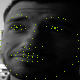
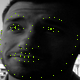
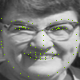
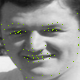
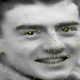
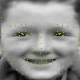
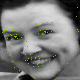
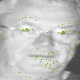


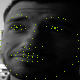
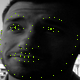
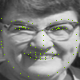
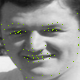
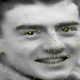
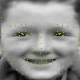
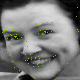
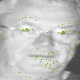

In [16]:
for responses, clips in results:
    for response, clip in zip(responses, clips):
        points = response.as_numpy(output_names[1]).squeeze()
        img = render_fpenet_image(clip, points)
        show_me_grid.append(img)
        show_me_labels.append(response.get_response().id)
ipyplot.plot_images(
    images=show_me_grid,
    img_width=160,
    labels=show_me_labels,
    show_url=False,
    max_images=max_images,
)

In [ ]:
# DEBUG
# facedetect_data = random.sample(facedetect_data, N_DEBUG)

In [ ]:
pbar = tqdm(
    total=len(facedetect_data),
    desc="Submitting photos to {} at {}".format(FPENET_MODEL_NAME, TRITON_SERVER_URL),
)

results = []

with ThreadPoolExecutor() as executor:
    for chunk in chunked(facedetect_data, THREAD_CHUNKS):
        futures = []
        for model in chunk:
            pbar.update()
            if model.faces[0].probability != 0:
                futures.append(
                    executor.submit(
                        submit_to_fpenet,
                        model,
                        input_names[0],
                        output_names,
                        request_id=model.filename,
                    )
                )

        for future in as_completed(futures):
            try:
                infer_result = future.result()
                results.append(infer_result)
            except Exception as e:
                print(
                    "There was an exception: {}\n{}.".format(
                        e, infer_result.get_response().id
                    )
                )

Submitting photos to fpenet at 172.25.4.42:8001:   0%|          | 0/31150 [00:00<?, ?it/s]

___